# Business Landscape and employee voices

This notebook aims to analyse the business landscape in 2015 as well as the employees reviews of some of the most influential companies.

In [1]:
import pandas
import pickle
import community
import numpy as np
import networkx as nx
import fa2_modified as fa2
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# DATA EXPLORATION

In [2]:
# read the companies
companies = pandas.read_csv('./archive/companies.csv')
print(companies.shape)

# read the links
links = pandas.read_csv('./archive/links.csv')
print(links.shape)

# read reviews
reviews = pandas.read_csv('./archive/employee_reviews.csv')
print(reviews.shape)


(51222, 6)


/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_16266/76708598.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  links = pandas.read_csv('./archive/links.csv')


(373663, 10)
(67529, 17)


We create a filtered list for the relationships we are interested in.

In [3]:
# print the different values of the link type
link_list = links['type'].unique()
links_filtered = ['partnership', 'customer', 'competitor', 'investment', 'supplier']


Next we check which companies we have reviews and the counts for each of them.

In [4]:
print(reviews['company'].unique())

# print number of reviews for each company
print(reviews['company'].value_counts())

['google' 'amazon' 'facebook' 'netflix' 'apple' 'microsoft']
company
amazon       26430
microsoft    17930
apple        12950
google        7819
facebook      1590
netflix        810
Name: count, dtype: int64


# CREATION OF THE GRAPH

This section does not need to be runned since the graph has been stored in a pickle file.

In [5]:
# create a directed graph where the nodes are the companies
G = nx.DiGraph()

for i, company in companies.iterrows():
    # if the node is not already in the graph, add it
    if company['name'] not in G.nodes:
        G.add_node(company['name'])
        # add an attribute
        G.nodes[company['name']]['domain'] = company['domain']

In [6]:
# create the edges between the companies
for i, link in links.iterrows():
    # if the node exist create an edge with the other node
    if link['home_name'] in G.nodes and link['link_name'] in G.nodes and link['type'] in links_filtered:
        G.add_edge(link['home_name'], link['link_name'])
        
        # add attributes to the edge
        G.edges[link['home_name'], link['link_name']]['type'] = link['type']

In [7]:
print(f"Nodes: {len(G.nodes)}")
print(f"Edges: {len(G.edges)}")

Nodes: 50535
Edges: 253657


In [8]:
# store the graph in a pickle .pkl file
with open('companies.pkl', 'wb') as f:
    pickle.dump(G, f)

# NETWORK ANALYSIS

In [9]:
# read the graph from the pickle file
with open('companies.pkl', 'rb') as f:
    G = pickle.load(f)

In [10]:
# The average clustering coefficient in a graph is a measure of how closely nodes in the graph 
# tend to cluster together. It reflects the likelihood that two neighbors of a node are also 
# neighbors themselves, giving insight into the local density of connections in the network.

# Determine the average clustering coefficient
print(f"Average clustering coeafficient {nx.average_clustering(G)}")

# Low average clustering coefficient: Suggests sparse or loosely connected groups, often seen
# in random or less-structured networks.

Average clustering coeafficient 0.08742918560244718


In [11]:

# Check if the graph is strongly connected
print(f"Strongly connected: {nx.is_strongly_connected(G)}")

# Check if the graph is weakly connected
print(f"Weakly connected: {nx.is_weakly_connected(G)}")

# Average shortest path lenght
if nx.is_strongly_connected(G):
    print(f"Average shortest path lenght {nx.average_shortest_path_length(G)}")
else: 
    print("The graph is not strongly connected so the average shortest path length is not defined")

Strongly connected: False
Weakly connected: False
The graph is not strongly connected so the average shortest path length is not defined


In [12]:
# Make the graph undirected to calculate density
G_undirected = G.to_undirected()

# Determine the density of the graph
print(f"Density {nx.density(G)}")

# The density of a graph is the ratio of the number of edges in the graph to the total number of
# possible edges in the graph. It is a measure of how many edges the graph has compared to the
# total number of edges that it could have.

# This graph has a very low density, which suggests that it is a sparse graph

Density 9.932782041355267e-05


In [13]:
# Study of largest connected components of the undirected graph
largest_connected_component = max(nx.connected_components(G_undirected), key=len)
G_largest_connected_component = G_undirected.subgraph(largest_connected_component)

print(f"Nodes in the largest connected component: {len(G_largest_connected_component.nodes)}")
print(f"Edges in the largest connected component: {len(G_largest_connected_component.edges)}")

# Determine the average clustering coefficient of the largest connected component
print(f"Average clustering coefficient of the largest connected component: {nx.average_clustering(G_largest_connected_component)}")

# Determine the density of the largest connected component
print(f"Density of the largest connected component: {nx.density(G_largest_connected_component)}")


Nodes in the largest connected component: 49758
Edges in the largest connected component: 190727
Average clustering coefficient of the largest connected component: 0.10588432899483778
Density of the largest connected component: 0.00015407247889076295


In [14]:
# HUBS

# The degree of a node in a network is the number of connections it has to other nodes.
# The in-degree of a node is the number of incoming connections it has from other nodes.
# The out-degree of a node is the number of outgoing connections it has to other nodes.

# The equality holds because every edge contributes exactly once to the in-degree of one node
# and once to the out-degree of another node. This is intrinsic to how directed edges are defined,
# making the sums (and therefore the averages) of in-degrees and out-degrees equal.

# Calculate average degree of the graph
degrees = [val for (node, val) in G.degree()]
print(f"Average degree: {sum(degrees)/len(G)}")

# Calculate the average in-degree of the graph
in_degrees = [val for (node, val) in G.in_degree()]
print(f"Average in-degree: {sum(in_degrees)/len(G)}")

# Calculate the average out-degree of the graph
out_degrees = [val for (node, val) in G.out_degree()]
print(f"Average out-degree: {sum(out_degrees)/len(G)}")

Average degree: 10.038864153556942
Average in-degree: 5.019432076778471
Average out-degree: 5.019432076778471


In [15]:
# calculate the degree centrality of the graph for in and out edges
in_degree_centrality = nx.in_degree_centrality(G)

# print the name of the five most central nodes
print("Most central in-degree nodes:")
print(sorted(in_degree_centrality, key=in_degree_centrality.get, reverse=True)[:10])

out_degree_centrality = nx.out_degree_centrality(G)
print("Most central out-degree nodes:")
print(sorted(out_degree_centrality, key=out_degree_centrality.get, reverse=True)[:10])

Most central in-degree nodes:
['Microsoft', 'Google', 'IBM', 'Facebook', 'Oracle', 'Cisco', 'SAP', 'Intel', 'Adobe', 'Dell']
Most central out-degree nodes:
['Cisco', 'Microsoft', 'Rackspace', 'Google', 'Oracle', 'IBM', 'Amazon Web Services', 'Facebook', 'SAP', 'NetApp']


In [16]:
# Measures a node's influence based on its connections to other highly influential nodes.

# Calculate the PageRank of the graph
pagerank_centrality = nx.pagerank(G)
print("Most central PageRank nodes:")
print(sorted(pagerank_centrality, key=pagerank_centrality.get, reverse=True)[:10])

# Compare with eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
print("Most central eigenvector centrality nodes:")
print(sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:10])

Most central PageRank nodes:
['Microsoft', 'Google', 'Facebook', 'IBM', 'Oracle', 'SAP', 'Cisco', 'Intel', 'Adobe', 'SUSE']
Most central eigenvector centrality nodes:
['Microsoft', 'Google', 'IBM', 'Facebook', 'Oracle', 'Cisco', 'SAP', 'Intel', 'Samsung', 'Adobe']


In [17]:
# Generate a list of the top 0.1% most central nodes by PageRank
sorted_nodes = sorted(pagerank_centrality, key=pagerank_centrality.get, reverse=True)

num_top_nodes = int(len(sorted_nodes) * 0.001)
top_nodes = [node for node in sorted_nodes[:num_top_nodes]]

# Create a subgraph with the top nodes
G_top = G.subgraph(top_nodes)

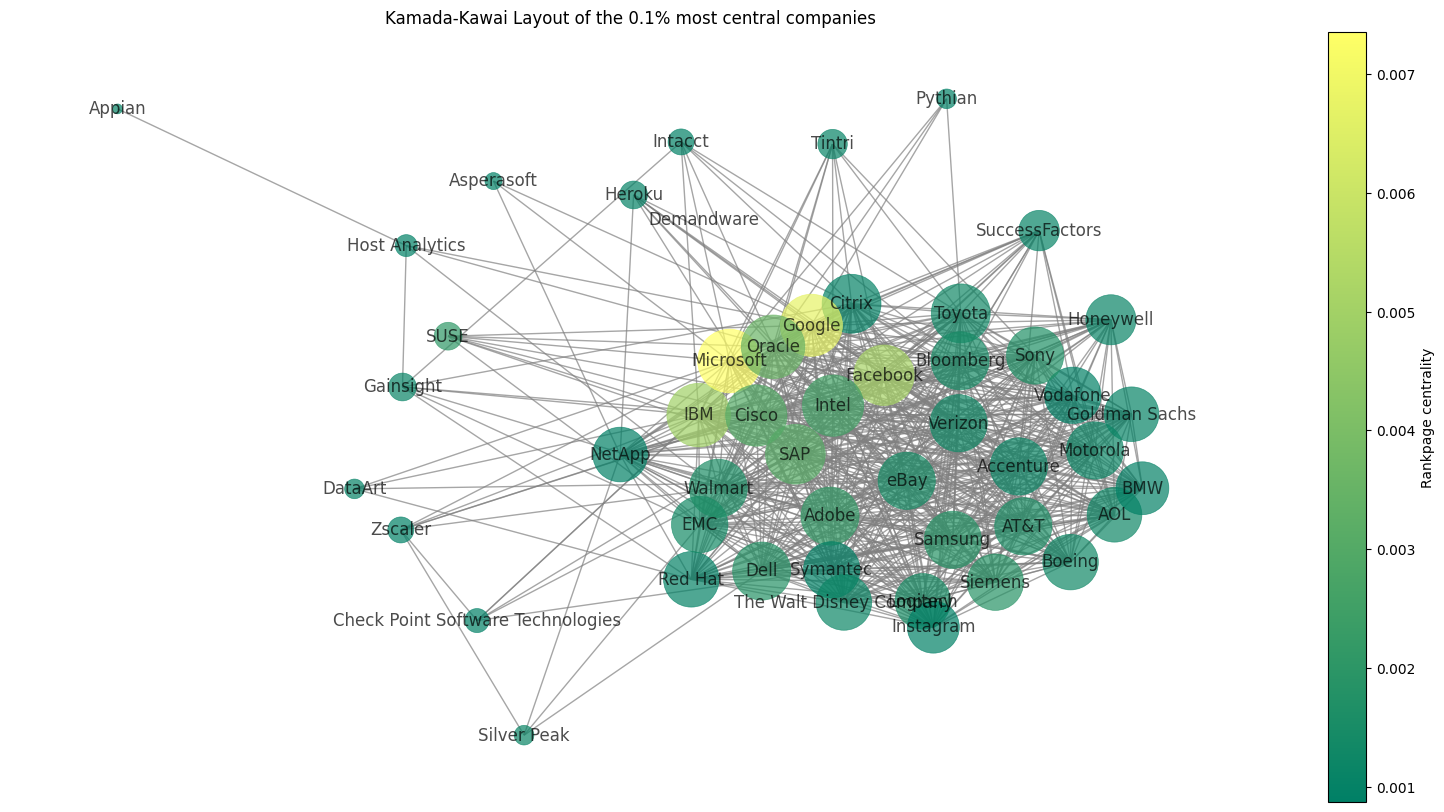

In [18]:
## GRAPH OF THE 0.1% MOST CENTRAL COMPANIES
# define the undirected graph
undir_g = G_top.to_undirected()

# plot the network
degrees_un = dict(undir_g.degree())

# Normalize node sizes based on degree (you can tweak scaling factor if necessary)
node_sizes_un = [degrees_un[node] * 50 for node in undir_g.nodes()]

# Get pagerank values for nodes
pagerank_values_un = [pagerank_centrality[node] for node in undir_g.nodes()]
# content_lengths = [nb.largest_c_subgraph.nodes[node].get('len_content', 0) for node in undir_g.nodes()]

# Normalize content lengths for color mapping
norm = plt.Normalize(vmin=min(pagerank_values_un), vmax=max(pagerank_values_un))
cmap = plt.get_cmap('summer')  # Choosing a simple sequential colormap

# Draw the network using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(undir_g)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Create the scalar mappable (for the color bar)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(pagerank_values_un)

# Draw the graph with customized node sizes and colors
nx.draw(
    undir_g, 
    pos, 
    ax=ax,
    with_labels=True,  # Remove labels for clarity
    node_size=node_sizes_un,  # Size of nodes based on degree
    node_color=pagerank_values_un,  # Color based on pagerank_values attribute
    cmap=cmap,  # Colormap for node colors
    edge_color='gray',  # Color of edges
    alpha=0.7,  # Transparency of edges
    linewidths=0.5  # Width of edges
)

# Add the color bar to the specific axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Rankpage centrality', color='black')  # Color of the color bar label

# Style adjustments
plt.title("Kamada-Kawai Layout of the 0.1% most central companies", color='black')
ax.tick_params(colors='black')  # White tick labels
plt.show()


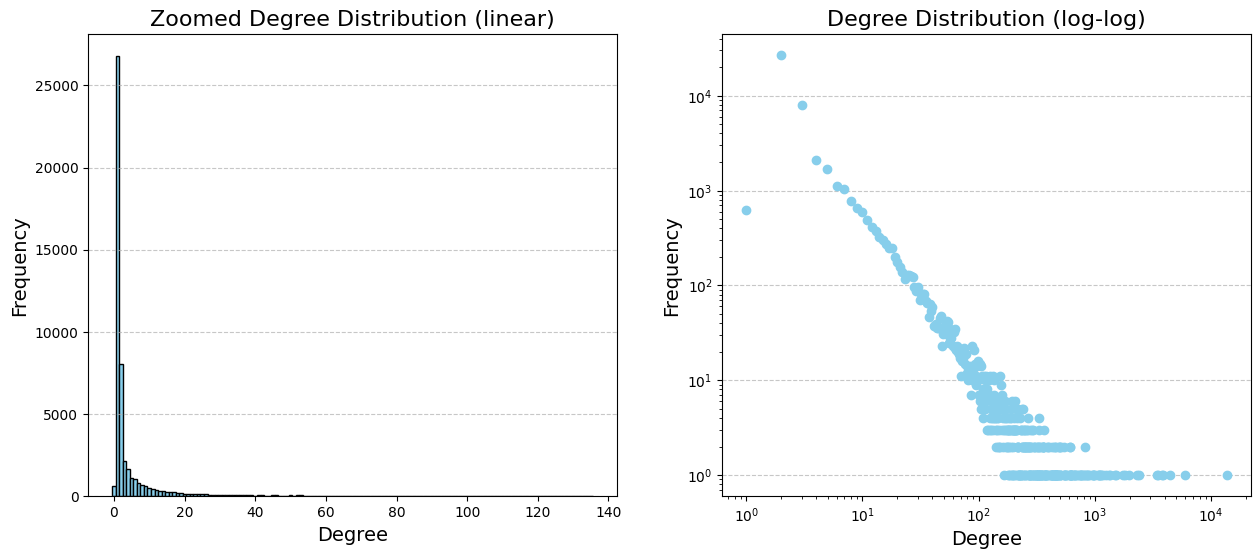

In [19]:
# Plot the degree distribution
plt.figure(figsize=(15, 6))

# Casted degree distribution
# Real max in 100 times bigger
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=range(min(degrees), int(max(degrees)/100) + 2), align='left', color='skyblue', edgecolor='black')
plt.title("Zoomed Degree Distribution (linear)", fontsize=16)
plt.xlabel("Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Original degree distribution
plt.subplot(1, 2, 2)
hist, bins = np.histogram(degrees, bins=len(range(min(degrees), max(degrees) + 2)))
plt.loglog(bins[1:], hist, 'o', color='skyblue')
# plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', color='skyblue', edgecolor='black')
plt.title("Degree Distribution (log-log)", fontsize=16)
plt.xlabel("Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
# Looks like a power-law distribution

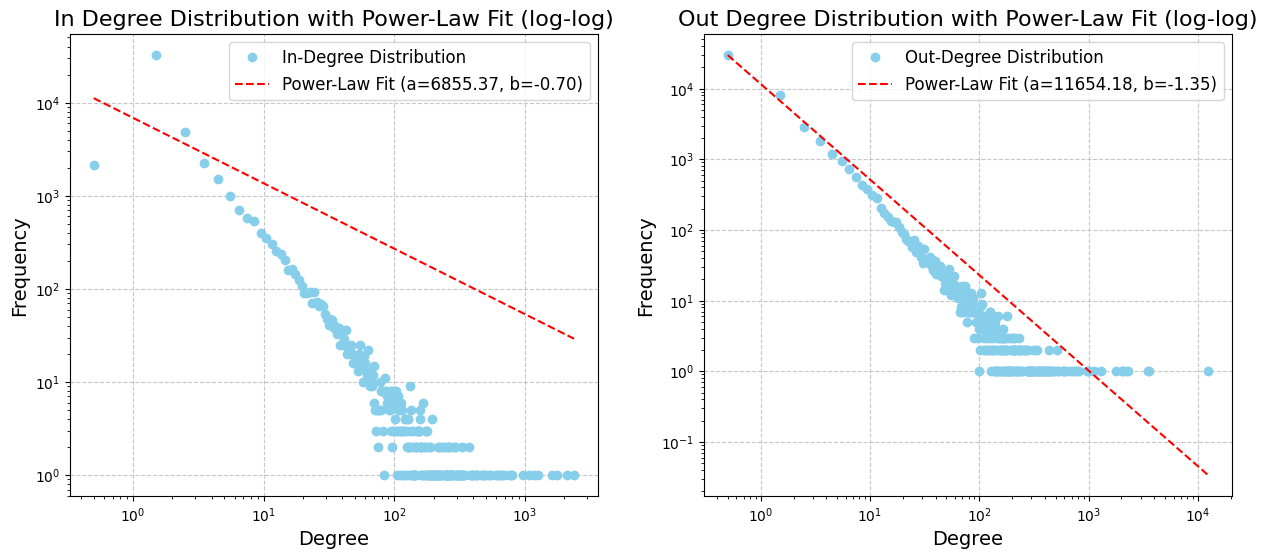

In [20]:
# Fit the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

def compute_hist_data(degrees):
    # Compute histogram data
    hist, bins = np.histogram(degrees, bins=len(range(min(degrees), max(degrees) + 2)))
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Bin centers for fitting

    # Filter bins with nonzero frequency for fitting
    nonzero_mask = hist > 0
    xdata = bin_centers[nonzero_mask]
    ydata = hist[nonzero_mask]

    # Fit the power-law curve
    params, _ = curve_fit(power_law, xdata, ydata)
    a, b = params

    # Step 2: Generate the power-law curve
    x_fit = np.linspace(min(xdata), max(xdata), 100)
    y_fit = power_law(x_fit, a, b)

    return bin_centers, hist, x_fit, y_fit, a, b

# Compute histogram data and power-law fit for in-degrees
bin_centers_in, hist_in, x_fit_in, y_fit_in, a_in, b_in = compute_hist_data(in_degrees)

# Compute histogram data and power-law fit for out-degrees
bin_centers_out, hist_out, x_fit_out, y_fit_out, a_out, b_out = compute_hist_data(out_degrees)

# Plot the degree distribution and power-law curve
plt.figure(figsize=(15, 6))

# Plot the in-degree distribution and power-law curve
plt.subplot(1, 2, 1)
plt.loglog(bin_centers_in, hist_in, 'o', color='skyblue', label='In-Degree Distribution')

# Plot the power-law fit
plt.loglog(x_fit_in, y_fit_in, '--', color='red', label=f'Power-Law Fit (a={a_in:.2f}, b={b_in:.2f})')

# Customize plot
plt.title("In Degree Distribution with Power-Law Fit (log-log)", fontsize=16)
plt.xlabel("Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Plot the out-degree distribution and power-law curve
plt.subplot(1, 2, 2)
plt.loglog(bin_centers_out, hist_out, 'o', color='skyblue', label='Out-Degree Distribution')

# Plot the power-law fit
plt.loglog(x_fit_out, y_fit_out, '--', color='red', label=f'Power-Law Fit (a={a_out:.2f}, b={b_out:.2f})')

# Customize plot
plt.title("Out Degree Distribution with Power-Law Fit (log-log)", fontsize=16)
plt.xlabel("Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.show()

# considering there is a 

## COMMUNITIES

In [ ]:
# do community detection based on the Louvain method
# Compute the best partition
# set a seed for reproducibility
partition = community.best_partition(G_undirected, random_state=33)

# Compute modularity
modularity = community.modularity(partition, G_undirected)
print(f"Modularity: {modularity}")

# Create a dictionary of communities
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []

    communities[community_id].append(node)
    
# Print the number of communities
print(f"Number of communities: {len(communities)}")

Modularity: 0.42275035629255825
Number of communities: 741


In [39]:
# Create a meta-graph
meta_graph = nx.Graph()
for com, nodes in communities.items():
    meta_graph.add_node(com, size=len(nodes))  # Add community node with size

    # measure the density of the community
    subgraph = G_undirected.subgraph(nodes)
    density = nx.density(subgraph)

    # add the density as a node attribute of the community node
    meta_graph.nodes[com]['density'] = density

    # Calculate internal and external degrees
    internal_edges = subgraph.number_of_edges()  # Edges within the community
    external_edges = sum(1 for node in nodes for neighbor in G_undirected.neighbors(node) if neighbor not in nodes)

    # Compute average internal and external degrees
    meta_graph.nodes[com]['avg_internal_degree'] = internal_edges / len(nodes)
    meta_graph.nodes[com]['avg_external_degree'] = external_edges / len(nodes)


print(f"Meta-graph nodes: {len(meta_graph.nodes)}")

# Calculate inter-community edges by aggregating connections between nodes in different communities
for u, v, data in G_undirected.edges(data=True):
    com_u = partition[u]
    com_v = partition[v]
    if com_u != com_v:  # Only inter-community edges
        weight = data.get('weight', 1)  # Use edge weight if it exists, default to 1
        if meta_graph.has_edge(com_u, com_v):
            meta_graph[com_u][com_v]['weight'] += weight
        else:
            meta_graph.add_edge(com_u, com_v, weight=weight)


print(f"Meta-graph edges: {len(meta_graph.edges)}")

# Extract node sizes and edge weights
node_sizes = [meta_graph.nodes[com]['size'] * 100 for com in meta_graph.nodes()]
edge_weights = [meta_graph[u][v]['weight'] for u, v in meta_graph.edges()]

Meta-graph nodes: 741
Meta-graph edges: 312


In [40]:
# create a copy of the meta_graph and remove the unconected nodes
meta_graph_copy = meta_graph.copy()
meta_graph_copy.remove_nodes_from(list(nx.isolates(meta_graph_copy)))
node_sizes = [meta_graph_copy.nodes[com]['size'] for com in  meta_graph_copy.nodes()]

print(f"Meta-graph nodes: {len(meta_graph_copy.nodes)}")

Meta-graph nodes: 92


Most central PageRank nodes:
[1, 0, 12, 19, 4]


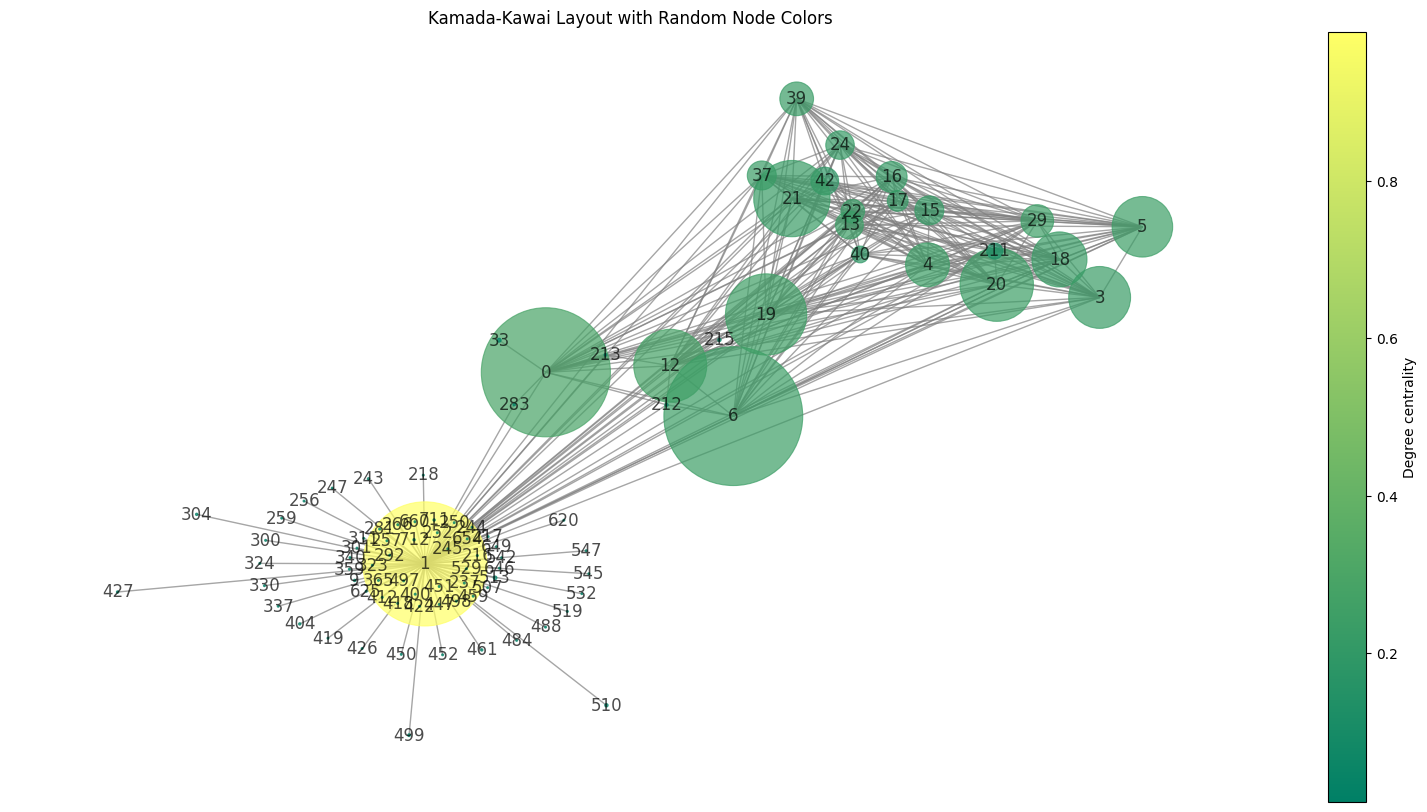

In [41]:
# Calculate centrality for the meta-graph since it is undirected
centrality_meta = nx.degree_centrality(meta_graph_copy)
print("Most central PageRank nodes:")
print(sorted(centrality_meta, key=centrality_meta.get, reverse=True)[:5])
# Get pagerank values for nodes
centrality_values = [centrality_meta[node] for node in meta_graph_copy.nodes()]

# Normalize content lengths for color mapping
norm = plt.Normalize(vmin=min(centrality_values), vmax=max(centrality_values))
cmap = plt.get_cmap('summer')  # Choosing a simple sequential colormap

# Draw the network using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(meta_graph_copy)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Create the scalar mappable (for the color bar)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(centrality_values)

# Draw the graph with customized node sizes and random colors
nx.draw(
    meta_graph_copy, 
    pos, 
    ax=ax,
    with_labels=True,  # Remove labels for clarity
    node_size=node_sizes,  # Size of nodes based on degree
    node_color=centrality_values,  # Assign random colors to nodes
    cmap=cmap,  # Colormap for nodes (optional if random colors are used)
    edge_color='gray',  # Color of edges
    alpha=0.7,  # Transparency of edges
    linewidths=0.8  # Width of edges
)

# Add the color bar to the specific axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Degree centrality', color='black')  # Color of the color bar label

# Optional: Add a legend or other stylistic elements
plt.title("Kamada-Kawai Layout with Random Node Colors", color='black')
ax.tick_params(colors='black')  # Black tick labels
plt.show()

In [42]:
# Five more influential communities information
data = []
for c in sorted(centrality_meta, key=centrality_meta.get, reverse=True)[:5]:
    data.append([c, meta_graph_copy.nodes[c]['size'], centrality_meta[c], np.mean([meta_graph_copy.degree(n) for n in meta_graph_copy.neighbors(c)]), meta_graph_copy.nodes[c]['density'], meta_graph_copy.nodes[c]['avg_internal_degree'], meta_graph_copy.nodes[c]['avg_external_degree']])

community_metrics= pandas.DataFrame(data, columns=['Community', 'Size', 'Centrality', 'Average degree', 'Density', 'Average internal degree', 'Average external degree'])
community_metrics.head()

,Community,Size,Centrality,Average degree,Density,Average internal degree,Average external degree
0,1,7986,0.989011,5.922222,0.002422,9.668044,4.914726
1,0,8641,0.285714,20.423077,0.000459,1.983451,2.221849
2,12,2758,0.274725,21.280000,0.001555,2.143220,5.073604
3,19,3421,0.252747,22.913043,0.000952,1.628764,1.902660
4,4,997,0.241758,23.863636,0.002195,1.093280,3.194584


## SENTIMENT ANALYSIS

First we clean the reviews based on what we have considered relevant columns as well as computing the unique companies and job titles. Another relevat fact is formating the dates.

In [26]:
# get the unique companies
companies = reviews['company'].unique()

# get the job titles
job_titles = reviews['job-title'].unique()


# filter the data based on the columns considered relevant
relevant_columns = ['company', 'dates', 'job-title', 'summary', 'pros', 'cons', 'advice-to-mgmt', 'overall-ratings']
filtered_reviews = reviews[relevant_columns]

# formatize the dates
filtered_reviews['dates'] = pandas.to_datetime(filtered_reviews['dates'], errors='coerce')

# drop possible null values
filtered_reviews = filtered_reviews.dropna(subset=['dates', 'overall-ratings'])

filtered_reviews['employee_status'] = filtered_reviews['job-title'].apply(lambda x: str(x).split(' ')[0])
filtered_reviews['job_pos'] = filtered_reviews['job-title'].apply(lambda x: str(x).split(' - ')[1])
count_data = filtered_reviews.groupby(['company', 'employee_status']).size().reset_index(name='count')

# get filtered job titles
jobs = filtered_reviews['job_pos'].unique()

# combine the summary, the pros, cons and advice-to-mgmt columns for sentiment analysis
sentiment_cols = ['summary', 'pros', 'cons', 'advice-to-mgmt']
filtered_reviews[sentiment_cols] = filtered_reviews[sentiment_cols].fillna("").astype(str)


/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_16266/1881694225.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews['dates'] = pandas.to_datetime(filtered_reviews['dates'], errors='coerce')


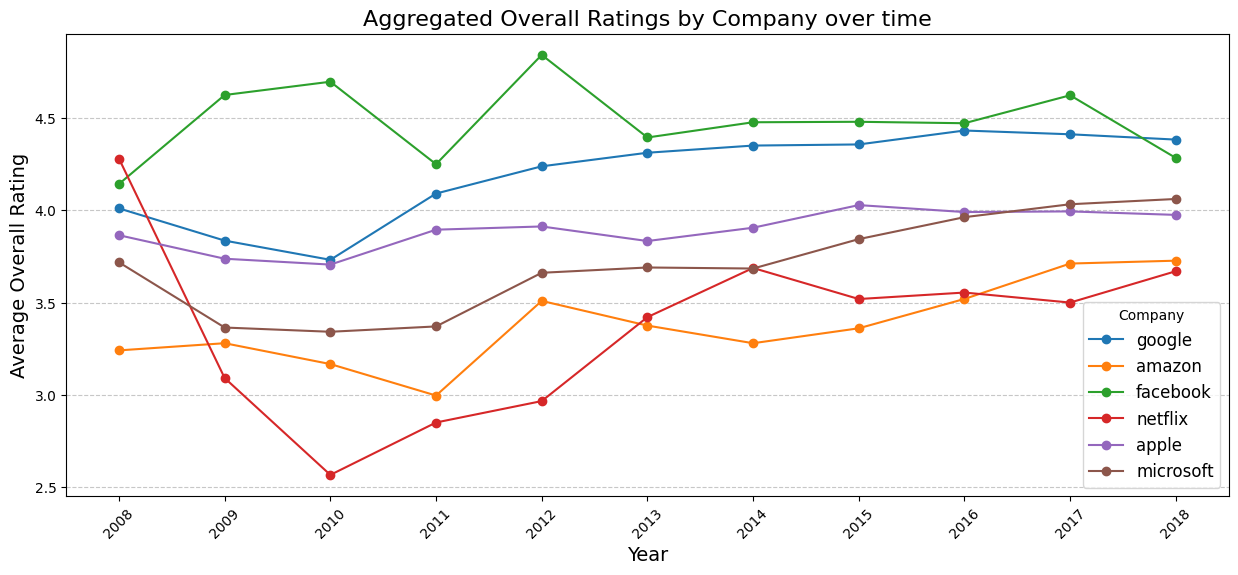

In [27]:
# Analyze the overall ratings of the reviews over time
filtered_reviews['year'] = pandas.to_datetime(filtered_reviews['dates']).dt.year

# Define the years range
years = range(filtered_reviews['dates'].min().year, filtered_reviews['dates'].max().year + 1)

# Initialize the figure
plt.figure(figsize=(15, 6))

# Plot aggregated ratings by year for each company
for company in companies:
    company_reviews = filtered_reviews[filtered_reviews['company'] == company]
    yearly_aggregated = (
        company_reviews[company_reviews['year'].isin(years)]
        .groupby('year')['overall-ratings']
        .mean()
    )
    plt.plot(yearly_aggregated.index, yearly_aggregated.values, marker='o', label=company)

# Customize plot
plt.title("Aggregated Overall Ratings by Company over time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Overall Rating", fontsize=14)
plt.xticks(years, rotation=45)
plt.legend(title="Company", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [28]:
filtered_reviews['feedback'] = filtered_reviews[sentiment_cols].apply(
    lambda row: '. '.join(filter(None, row)), axis=1
)

In [29]:
# Tokenize the feedback
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
quotes = ['``', "''", '’', '""', '“', '”']

labmt_df = pandas.read_csv('./public/DataSet.csv', delimiter=";")

happiness_dict = dict(zip(labmt_df['word'], labmt_df['happiness_average']))

In [30]:
#Sentiment calculation function
def calculate_sentiment(tokens):
    sentiment = 0
    for token in tokens:
        if token in happiness_dict:
            sentiment += happiness_dict[token]
    return round(sentiment, 2)

In [31]:
def calculate_feedback_happiness(feedback):
    tokens = word_tokenize(feedback.lower())
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if len(word) > 1 and word not in quotes]
    sentiment = sum(happiness_dict.get(token, 0) for token in tokens)
    return sentiment / len(tokens) if tokens else 0

In [32]:
# Calculate sentiment for the feedback grouped by each company
feedback_sentiment = {}

for company, feedbacks in filtered_reviews.groupby('company')['feedback']:
    combined_feedback = " ".join(feedbacks).lower()
    tokens = word_tokenize(combined_feedback)
    tokens = [word.lower() for word in tokens if word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if len(word) > 1 and word not in quotes]
    sentiment_score = calculate_sentiment(tokens)
    feedback_sentiment[company] = round(sentiment_score, 4)

# Display sentiment scores for each company
feedback_sentiment


{'amazon': 5261596.48,
 'apple': 2713823.41,
 'facebook': 393111.55,
 'google': 1329924.65,
 'microsoft': 3704287.61,
 'netflix': 256918.2}

In [33]:
sentiment_values = list(feedback_sentiment.values())

avg_sentiment = np.mean(sentiment_values)
median_sentiment = np.median(sentiment_values)
variance_sentiment = np.var(sentiment_values)
percentile_25 = np.percentile(sentiment_values, 25)
percentile_75 = np.percentile(sentiment_values, 75)


print(f"Average sentiment: {avg_sentiment:.2f}")
print(f"Median sentiment: {median_sentiment:.2f}")
print(f"Variance sentiment: {variance_sentiment:.2f}")
print(f"25th percentile: {percentile_25:.2f}")
print(f"75th percentile: {percentile_75:.2f}")

Average sentiment: 2276610.32
Median sentiment: 2021874.03
Variance sentiment: 3277082956634.27
25th percentile: 627314.82
75th percentile: 3456671.56


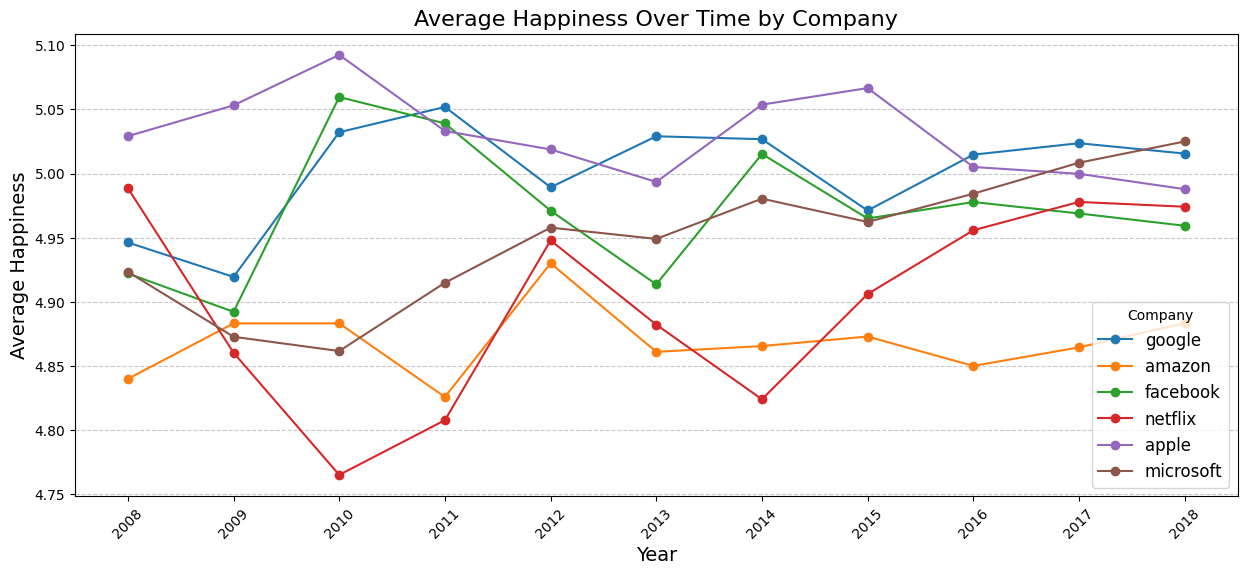

In [34]:
# Ensure 'year' column is in the dataset (convert if necessary)
filtered_reviews['year'] = pandas.to_datetime(filtered_reviews['dates']).dt.year

# Define the years range
years = range(filtered_reviews['dates'].min().year, filtered_reviews['dates'].max().year + 1)

# Calculate happiness average for each feedback
filtered_reviews['happiness_average'] = filtered_reviews['feedback'].apply(calculate_feedback_happiness)

# Initialize the figure
plt.figure(figsize=(15, 6))

# Plot average happiness over time for each company
for company in companies:
    company_reviews = filtered_reviews[filtered_reviews['company'] == company]
    happiness_over_time = (
        company_reviews
        .groupby(['year'])['happiness_average']
        .mean()
        .reset_index()
    )
    plt.plot(happiness_over_time['year'], happiness_over_time['happiness_average'], marker='o', label=company)

# Customize plot
plt.title("Average Happiness Over Time by Company", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Happiness", fontsize=14)
plt.xticks(years, rotation=45)
plt.legend(title="Company", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### CALCULATE AND VISUALIZE TD-IDFs

In [35]:
# Group feedback by company or other categories
grouped_feedback = filtered_reviews.groupby('company')['feedback'].apply(' '.join).reset_index()

In [36]:
# TF-IDF Vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(grouped_feedback['feedback'])
tfidf_df = pandas.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=grouped_feedback['company'])

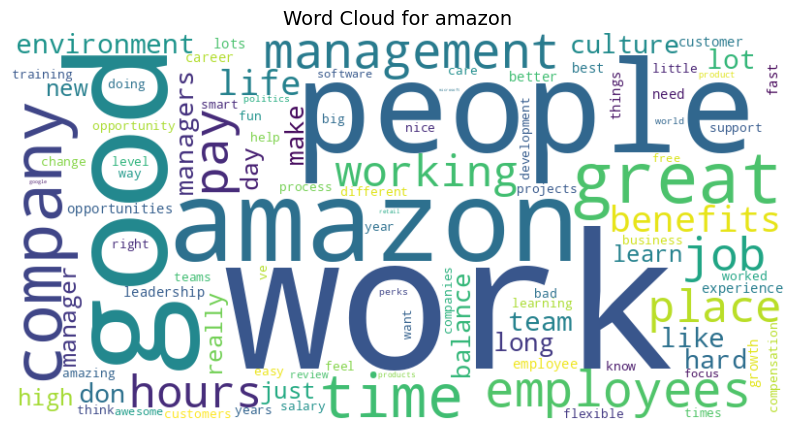

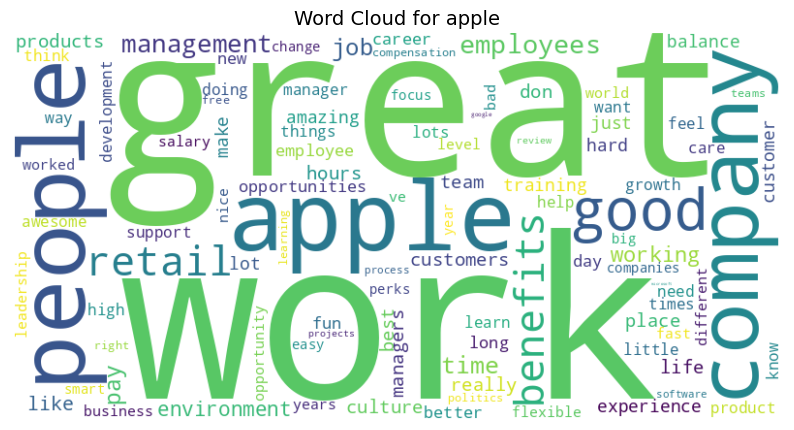

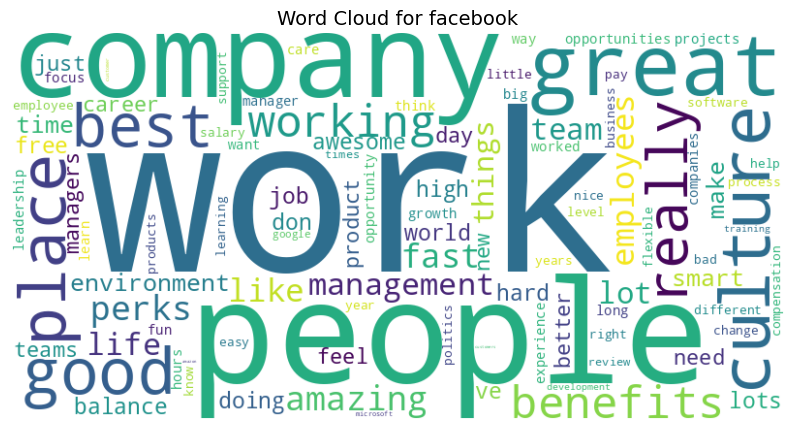

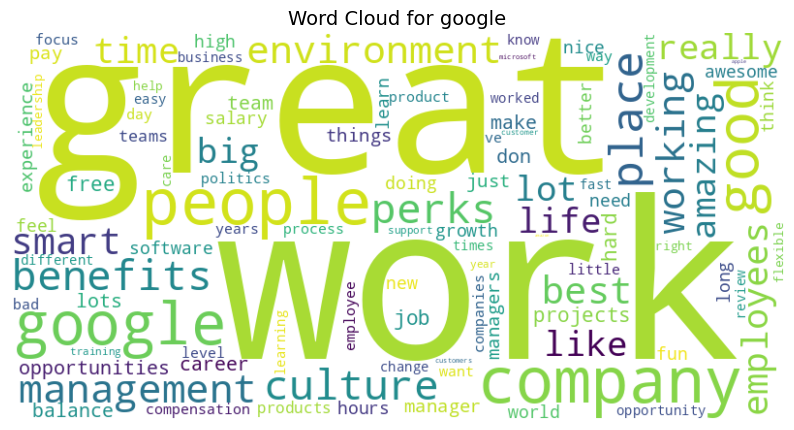

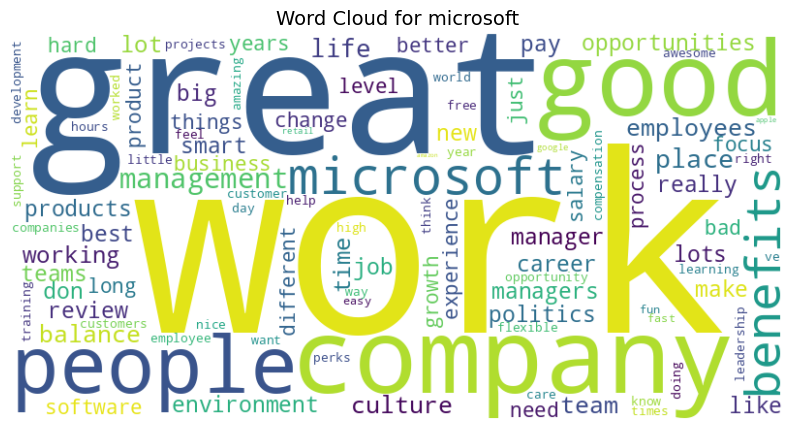

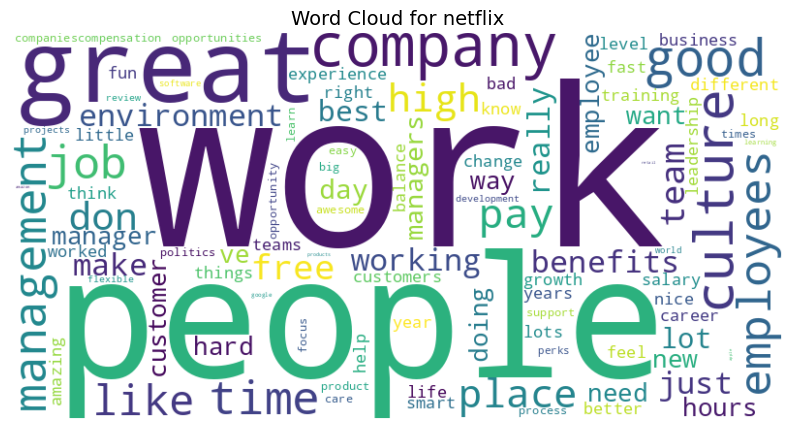

In [37]:
# Word Cloud for Each Company
for company in tfidf_df.index:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
        tfidf_df.loc[company].to_dict()
    )
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {company}", fontsize=14)
    plt.show()